In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import logging
logging.basicConfig()

from pathlib import Path
from pprint import pprint
import itertools

from tqdm import tqdm, trange

import numpy as np
import matplotlib.pyplot as plt
import skimage
import cv2 as cv

import quinoa as q

In [2]:
NOTEBOOK_NAME = "io"

HERE = Path.cwd().absolute()
DATA = HERE.parent / "data"
OUT = HERE / "out" / Path(NOTEBOOK_NAME).stem
print(HERE)
print(DATA)
print(OUT)

D:\projects\quinoa\dev
D:\projects\quinoa\data
D:\projects\quinoa\dev\out\io


In [3]:
img_bgr = q.read_image(DATA / "IMG_0477.JPG")
# img_bgr = q.read_image(DATA / "IMG_0497.JPG")
# img_bgr = q.read_image(DATA / "IMG_9465.JPG")

print(img_bgr.shape)

(2432, 3648, 3)


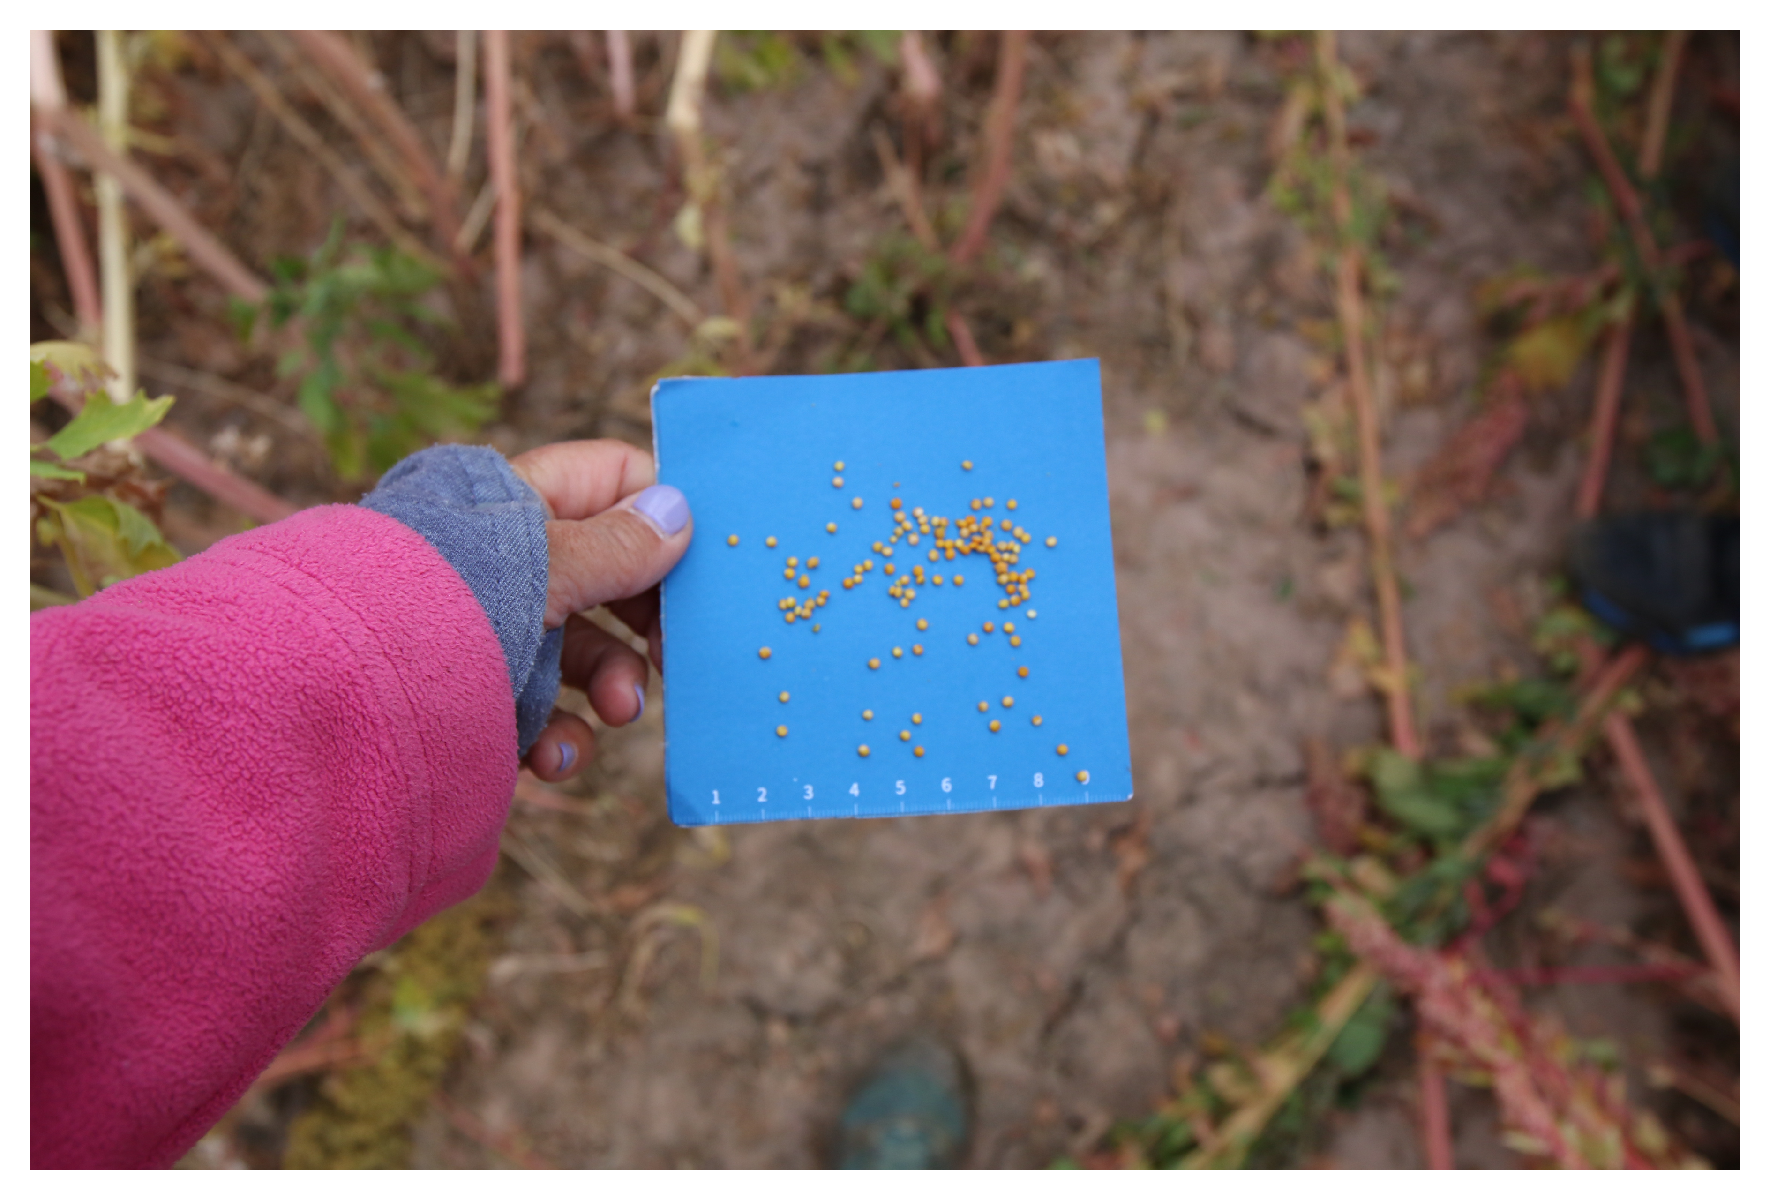

In [4]:
q.show_image(q.convert_colorspace(img_bgr, cv.COLOR_BGR2RGB))

In [5]:
img_lab = q.convert_colorspace(img_bgr, cv.COLOR_BGR2LAB)

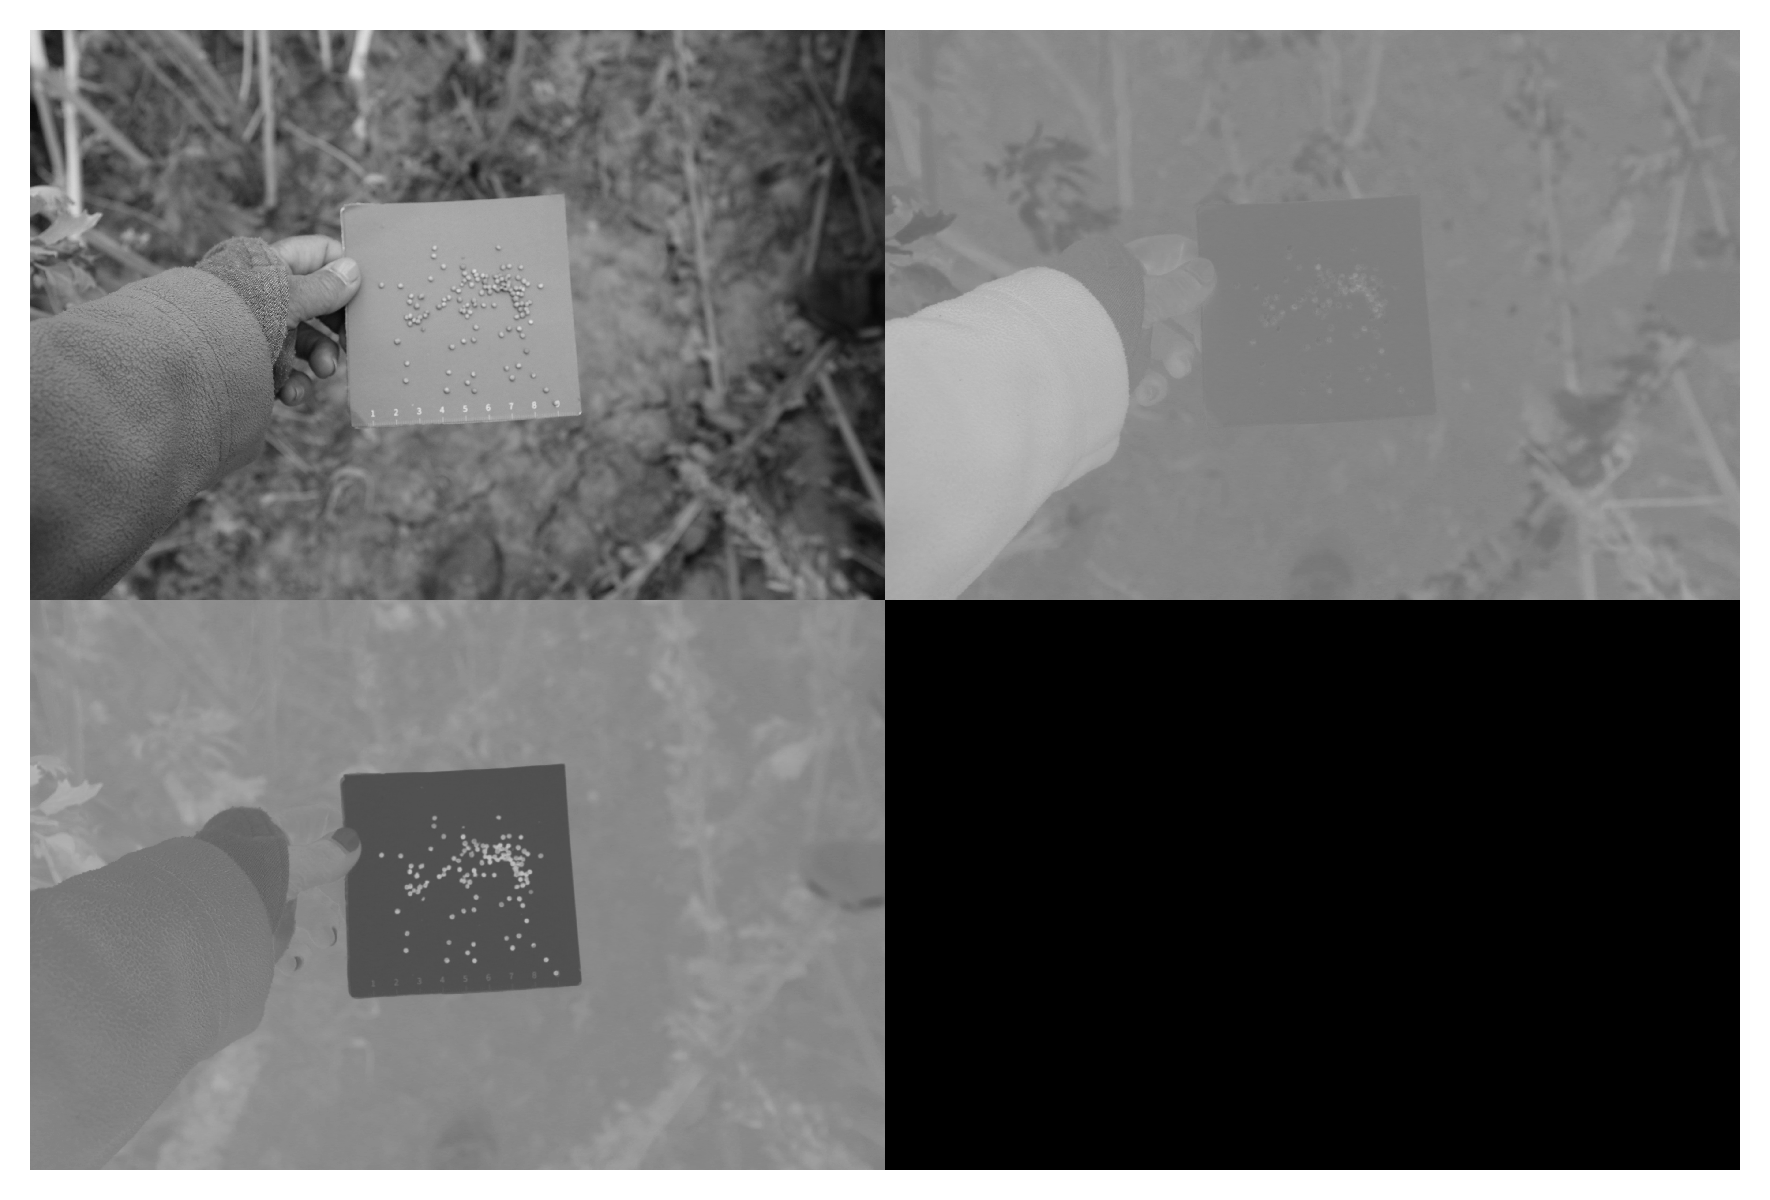

In [6]:
q.show_image(
    skimage.util.montage(np.moveaxis(img_lab, [-1], [0]), fill = 0)
)

(2432, 3648) uint8


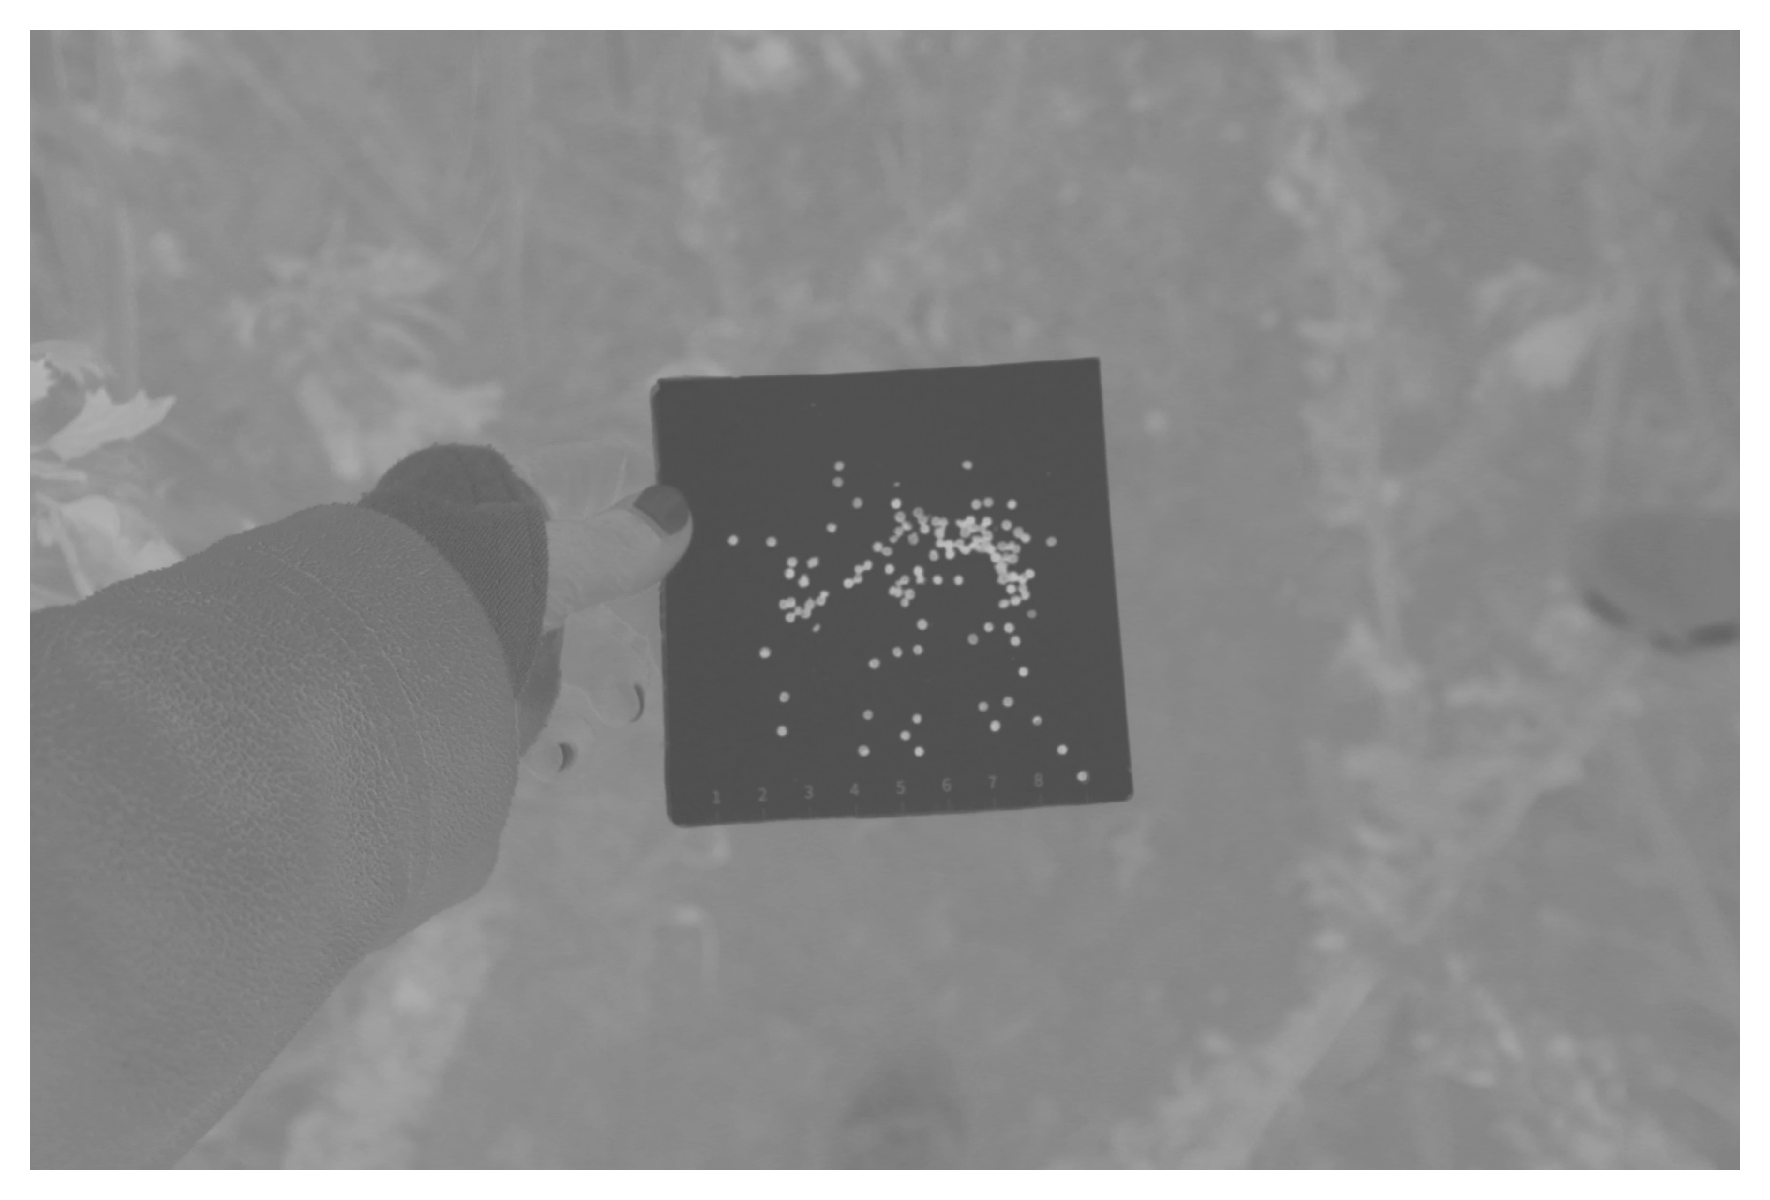

In [7]:
img_b = img_lab[..., 2]
print(img_b.shape, img_b.dtype)

q.show_image(img_b)

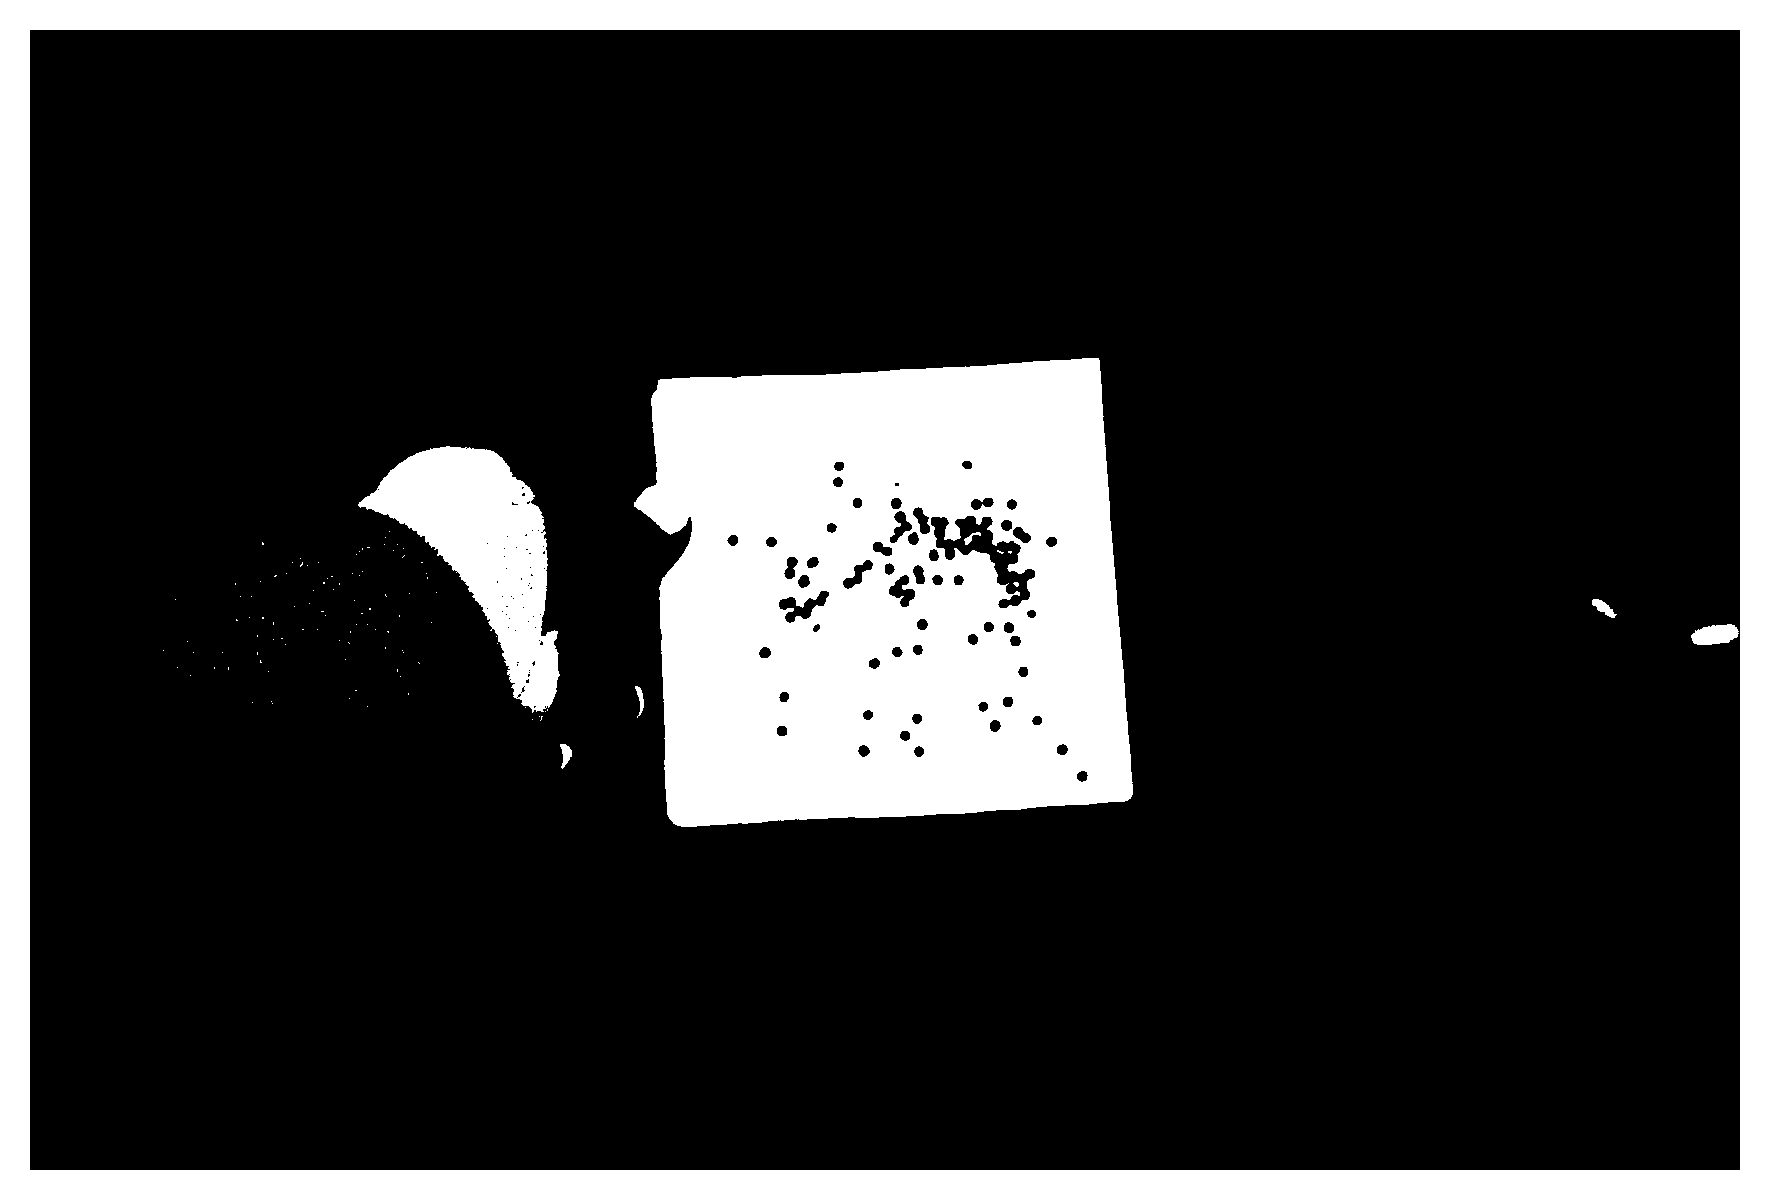

In [8]:
thresh, thresholded = cv.threshold(cv.bitwise_not(img_b), 0, maxval = 255, type = cv.THRESH_OTSU)

q.show_image(thresholded)

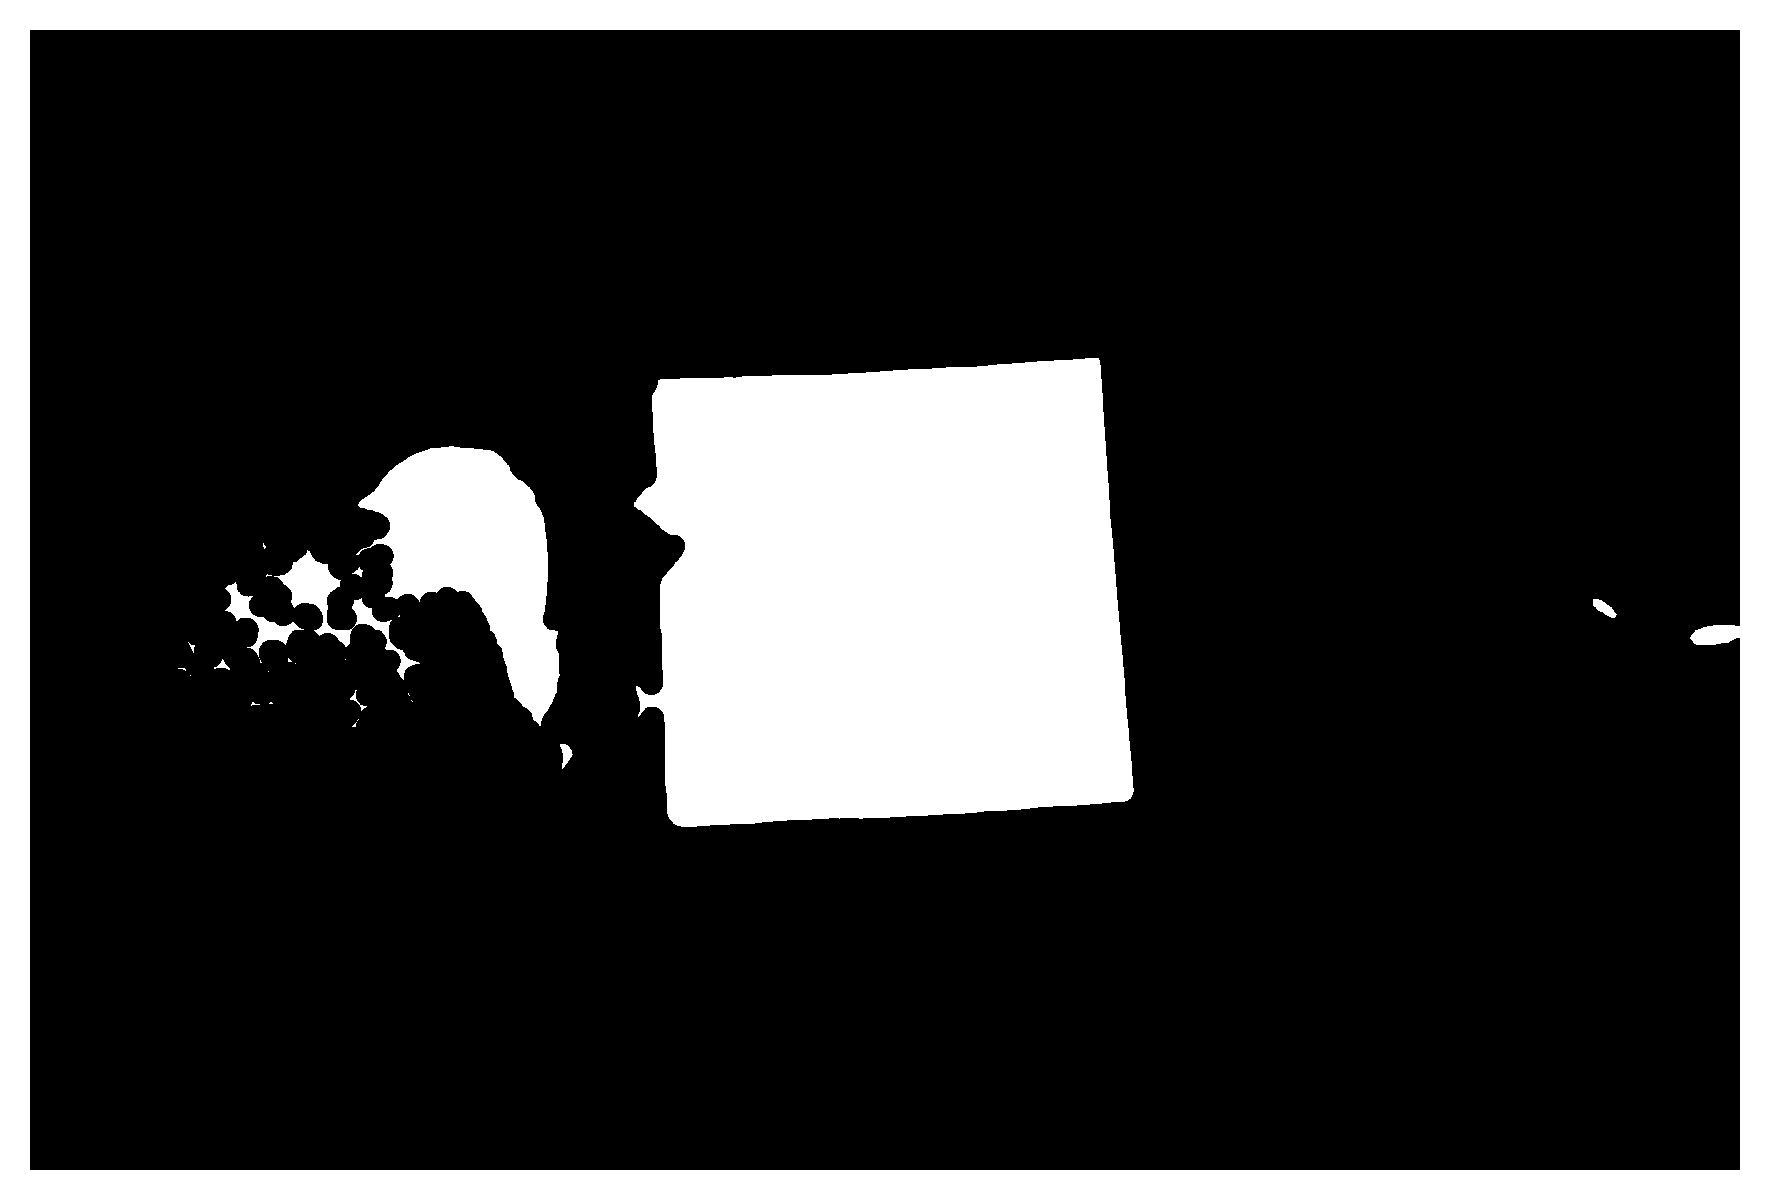

In [9]:
closed = cv.morphologyEx(
    thresholded,
    cv.MORPH_CLOSE,
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (50, 50))
)

q.show_image(closed)

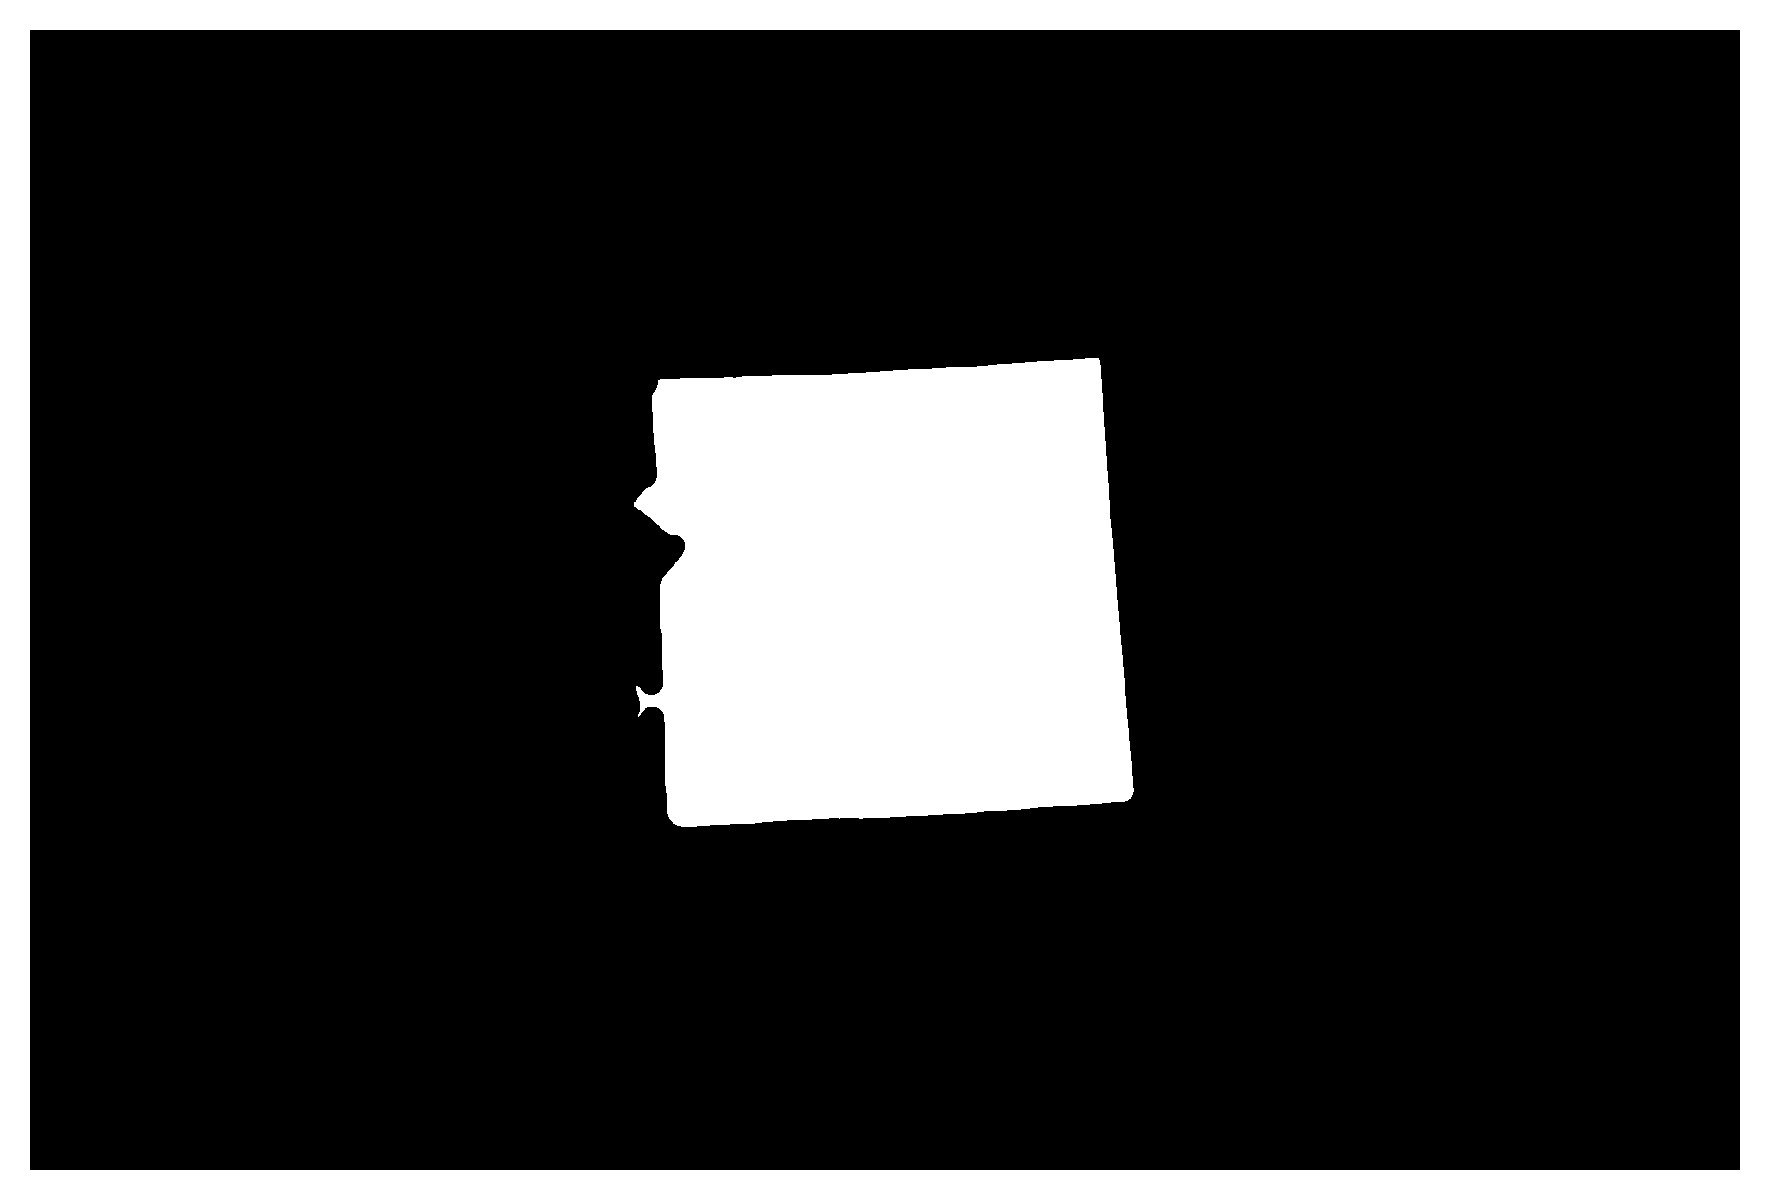

In [10]:
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(closed, connectivity = 8)

largest_label = max(range(1, num_labels), key = lambda label: stats[label, cv.CC_STAT_AREA])

just_largest_component = np.where(labels == largest_label, closed, 0)

q.show_image(just_largest_component)

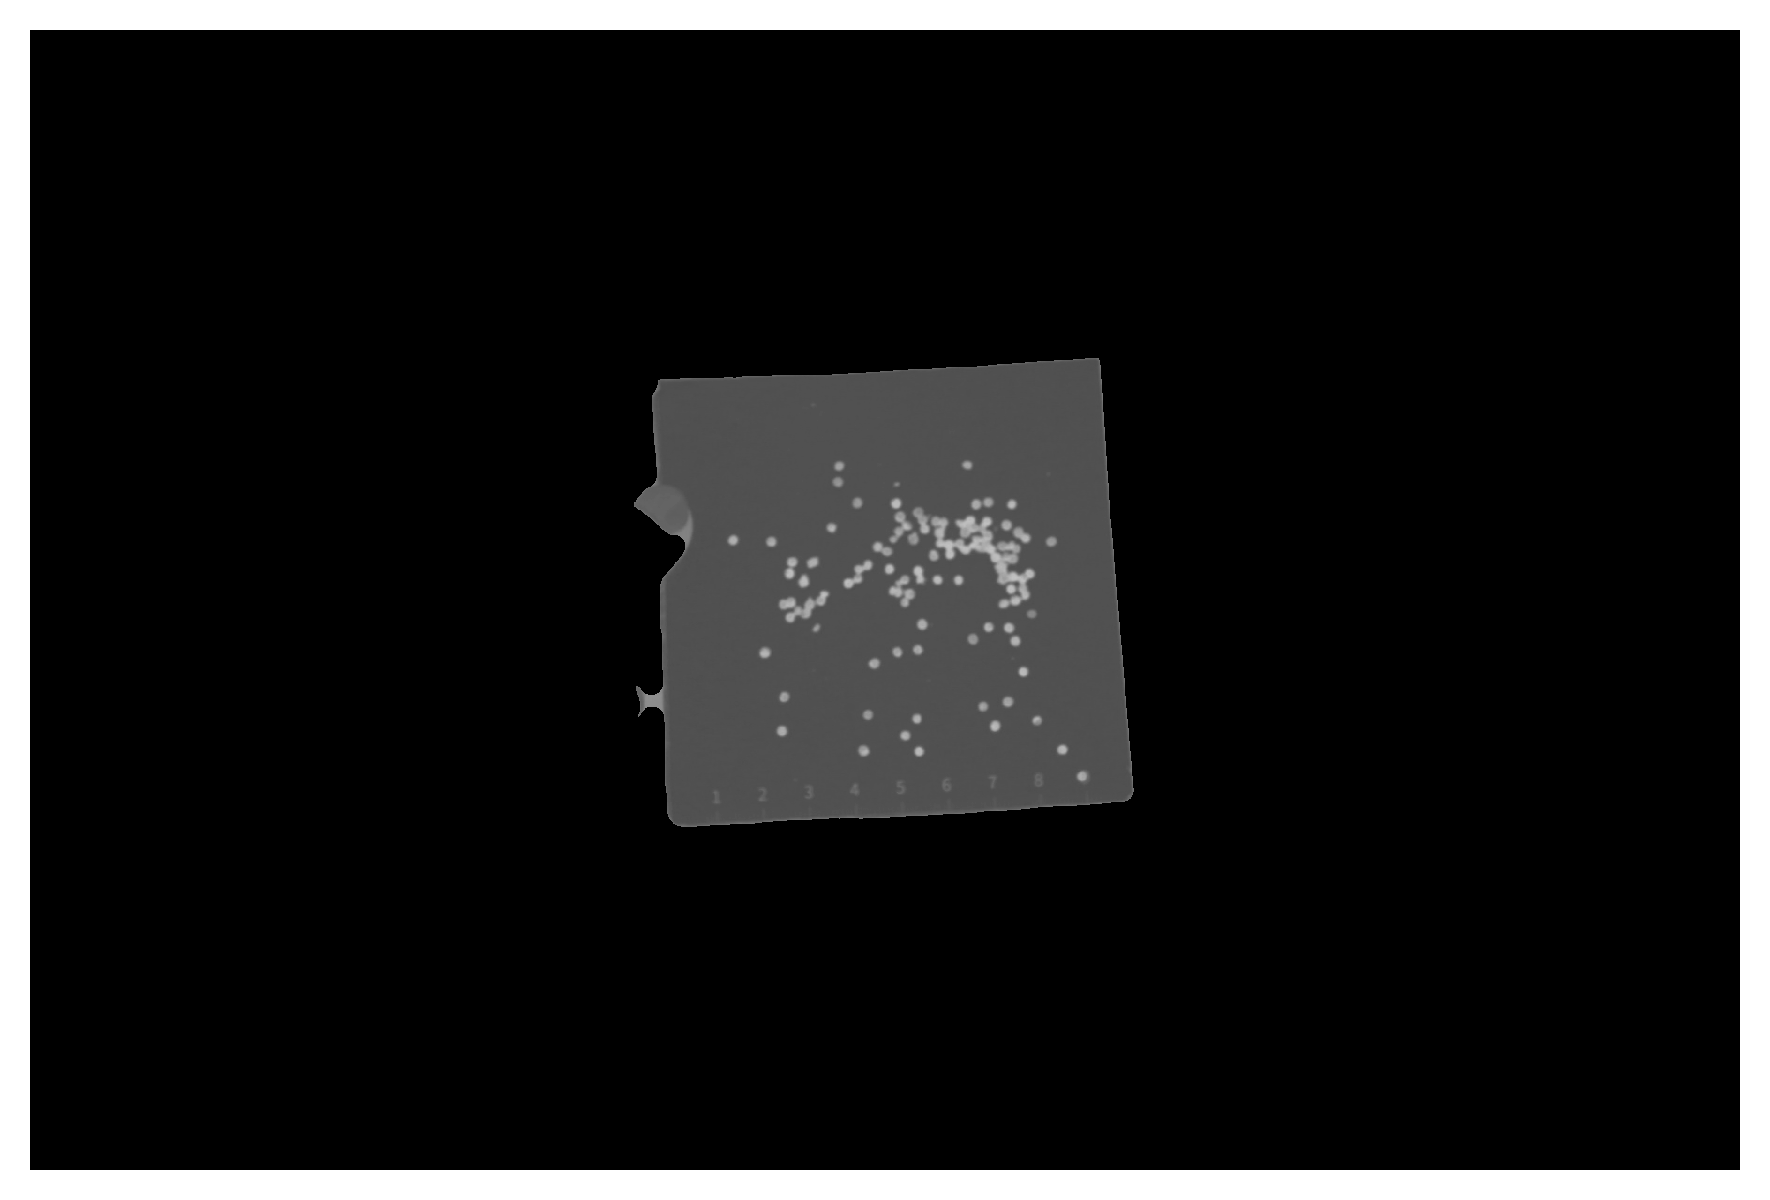

In [11]:
largest_component_on_original = np.where(labels == largest_label, img_b, 0)

q.show_image(largest_component_on_original)

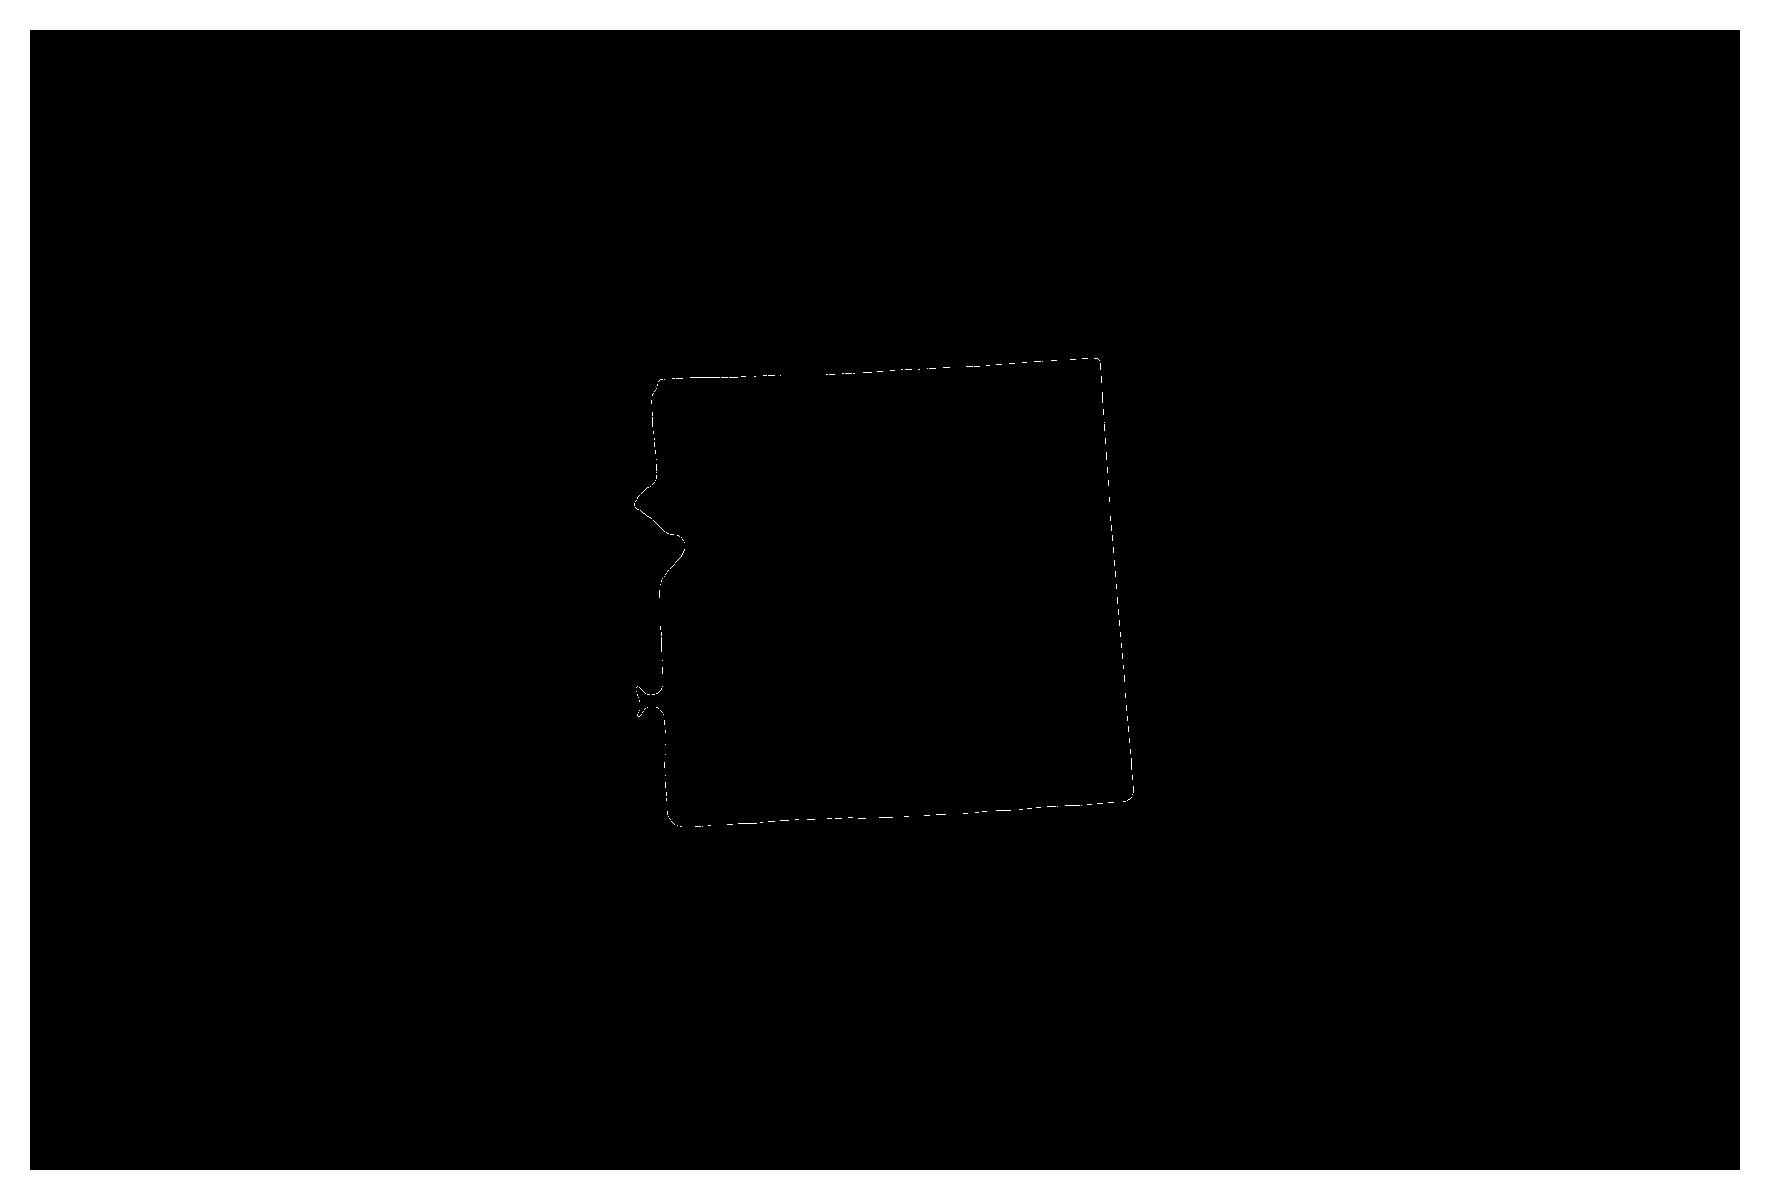

In [13]:
edges = cv.Canny(cv.GaussianBlur(just_largest_component, (21, 21), 3), 10, 100, apertureSize = 7, L2gradient = True)

q.show_image(edges)

(19, 4)


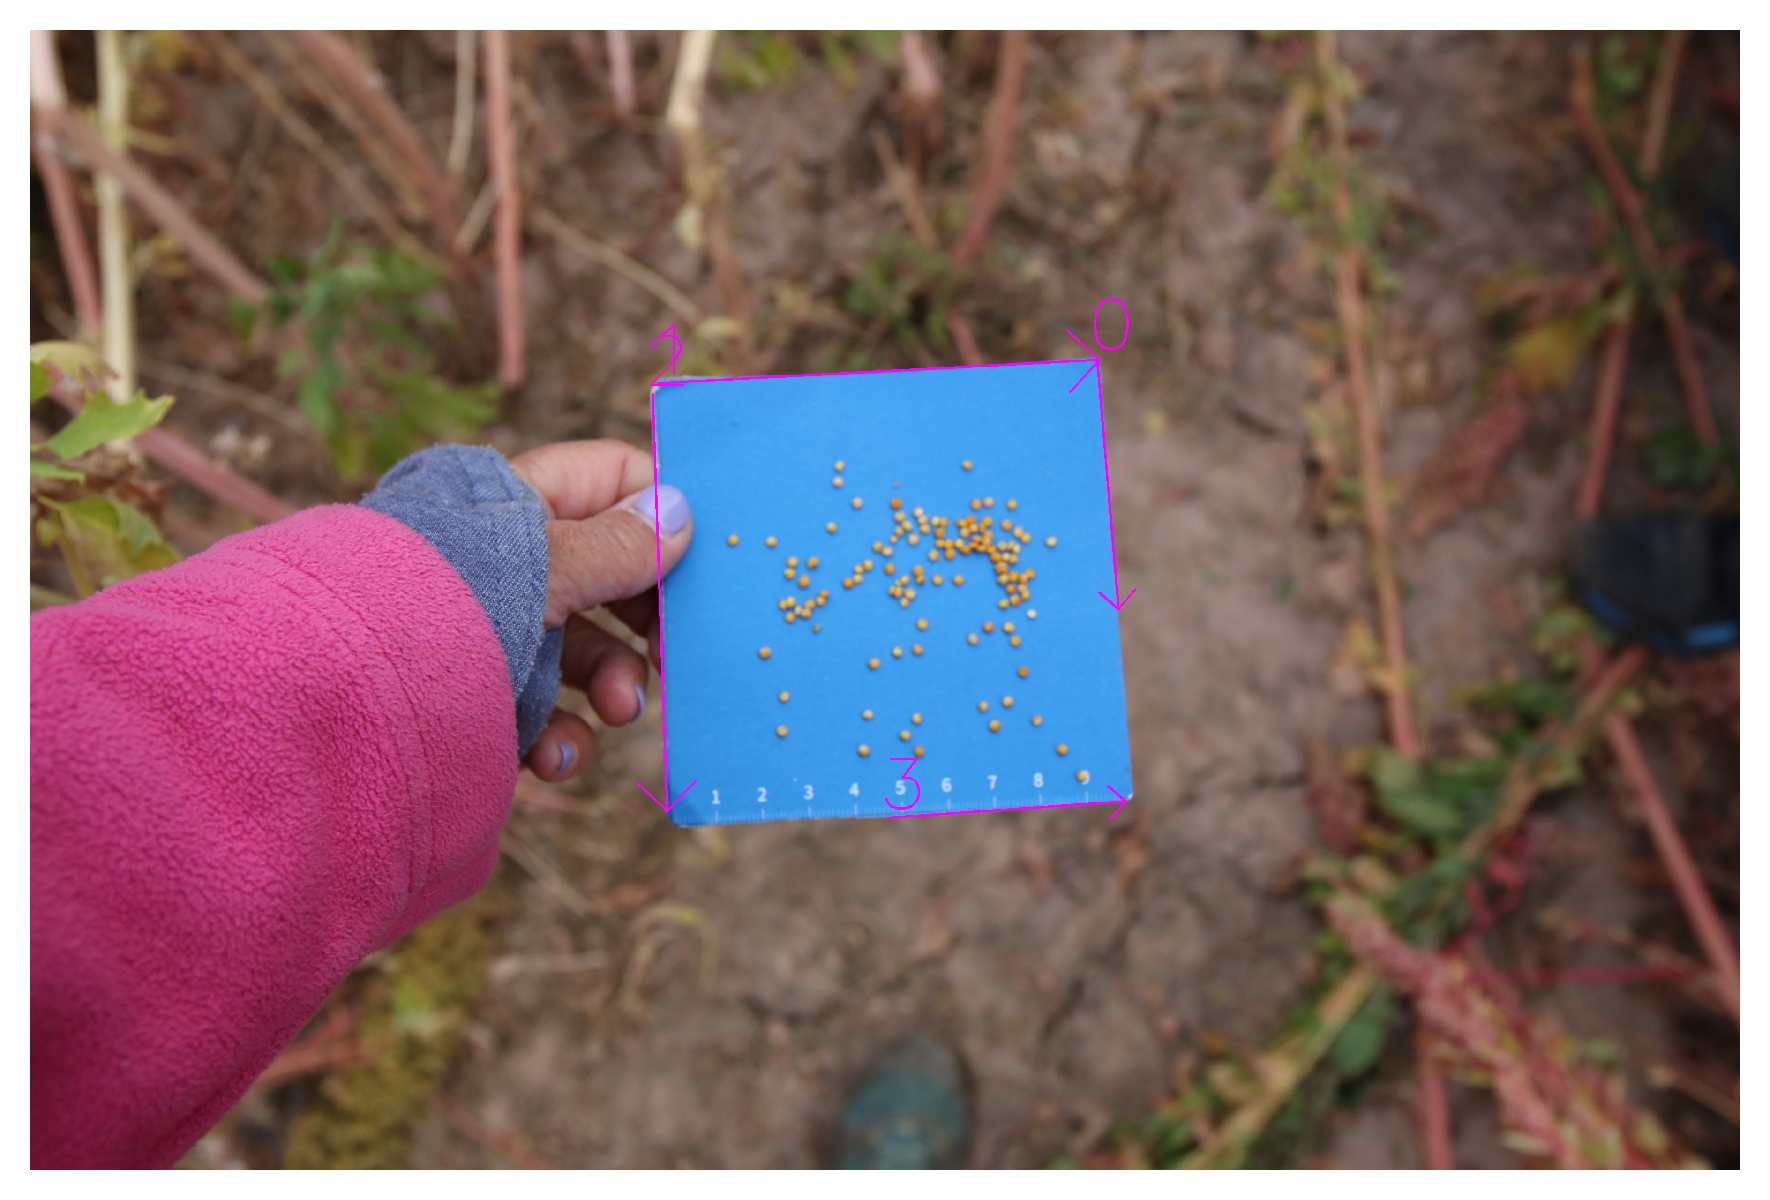

In [14]:
lines = cv.HoughLinesP(
    edges,
    rho = 4,
    theta = np.deg2rad(1),
    threshold = 100,
    minLineLength = 200,
    maxLineGap = 500,
).squeeze()

print(lines.shape)

show_lines = img_bgr.copy()

for idx, ((xs, ys, xe, ye), color) in enumerate(zip(lines[:4], itertools.repeat(q.PINK))):
    show_lines = q.draw_arrow(
        show_lines,
        (xs, ys),
        (xe, ye),
        color = color,
        thickness = 3,
    )
    show_lines = q.draw_text(
        show_lines,
        (xs - 20, ys - 20),
        str(idx),
        color = color,
        size = 5,
        thickness = 3,
    )
    
# show_lines = q.draw_rectangle(
#     show_lines,
#     (stats[largest_label, cv.CC_STAT_LEFT], stats[largest_label, cv.CC_STAT_TOP]),
#     (stats[largest_label, cv.CC_STAT_LEFT] + stats[largest_label, cv.CC_STAT_WIDTH], stats[largest_label, cv.CC_STAT_TOP] + stats[largest_label, cv.CC_STAT_HEIGHT]),
#     color = q.RED,
#     thickness = 3,
# )

q.show_image(q.convert_colorspace(show_lines, cv.COLOR_BGR2RGB))